In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

In [ ]:
!ls german-traffic-signs

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D
import random
import pickle
import pandas as pd

In [24]:
# generate the same random numbers each time
np.random.seed(0)

In [25]:
# open the train pickle file as f, and read it as binary
with open('german-traffic-signs/train.p', 'rb') as f:
    # load the training data
    train_data = pickle.load(f)

# open the valid pickle file as f, and read it as binary
with open('german-traffic-signs/valid.p', 'rb') as f:
    # load the validation data
    valid_data = pickle.load(f)

# open the test pickle file as f, and read it as binary
with open('german-traffic-signs/test.p', 'rb') as f:
    # load the test data
    test_data = pickle.load(f)

In [26]:
print(type(train_data))
# declare samples and labels for each branch of dataset
X_train, Y_train = train_data['features'], train_data['labels']
X_valid, Y_valid = valid_data['features'], valid_data['labels']
X_test, Y_test = test_data['features'], test_data['labels']

<class 'dict'>


In [27]:
# print the shape of samples, they're 3D due to RGB
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [28]:
# test the data validity
assert(X_train.shape[0] == Y_train.shape[0]), "The number of train images isn't equal to the number of labels"
assert(X_valid.shape[0] == Y_valid.shape[0]), "The number of valid images isn't equal to the number of labels"
assert(X_test.shape[0] == Y_test.shape[0]), "The number of test images isn't equal to the number of labels"
assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of train images aren't 32x32x3"
assert(X_valid.shape[1:] == (32, 32, 3)), "The dimensions of valid images aren't 32x32x3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of test images aren't 32x32x3"

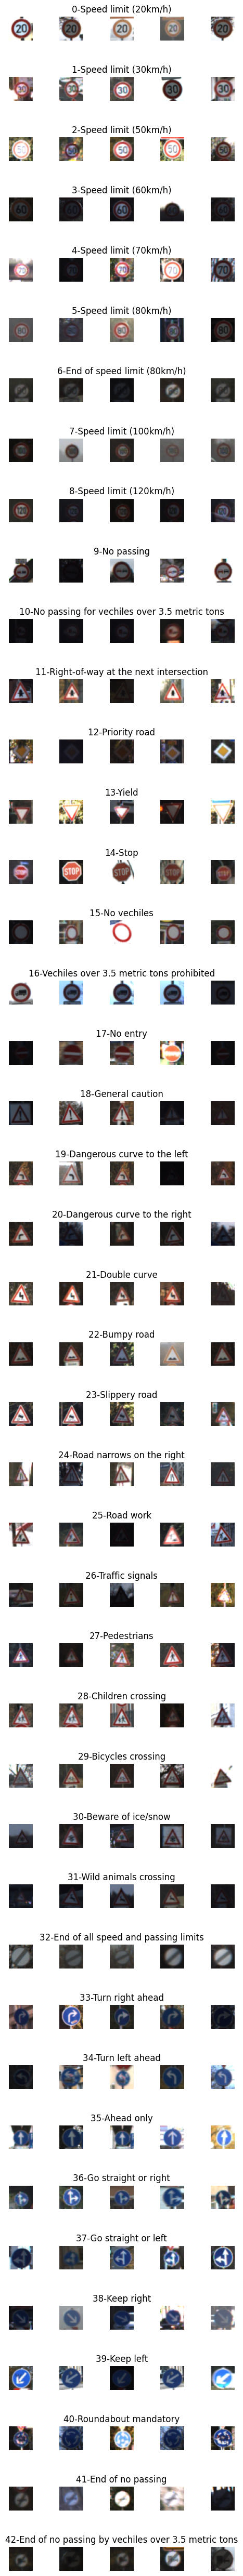

In [29]:
# read the csv of sign names using pandas
data = pd.read_csv('german-traffic-signs/signnames.csv')
# store the number of each class
num_of_samples = []
# declare cols for the number of columns to display, and number of classes, that is the number of signs
cols = 5
num_classes = 43
# declare fig to display a figure for randomly selected samples
# declare axs to access each region of the subplot figure
# create a subplot number of classes x number of columns, each in size 5x50 inches
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 50))
# tighten the figure to omit the conflicts between regions
fig.tight_layout()
# iterate on axis to display randomly selected samples
for i in range(cols):
    # iterate on the rows of data
    for j, row in data.iterrows():
        # select all desired samples of class j
        x_selected = X_train[Y_train==j]
        # randomly select a sample and show it in the desired axis in gray-scale
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected)-1), :, :], cmap=plt.get_cmap("gray"))
        # don't show the axis for each region
        axs[j][i].axis("off")
        if i == 2:
            # show the title of the desired class on the middle column plus the name of road sign
            axs[j][i].set_title(f"{str(j)}-{row['SignName']}")
            # store the number of desired class
            num_of_samples.append(len(x_selected))

Text(0, 0.5, 'Number of images(samples)')

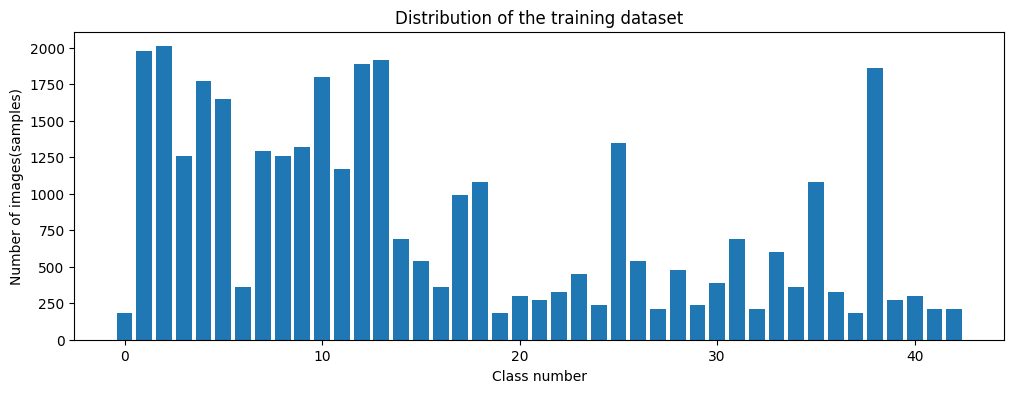

In [30]:
# create a figure to display distribution of classes
plt.figure(figsize=(12, 4))
# create a bar graph, x axis includes the class number and y axis indlude number of images
plt.bar(range(0, num_classes), num_of_samples)
# title the bar graph and its axis
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images(samples)")

(34799, 32, 32, 3)
4


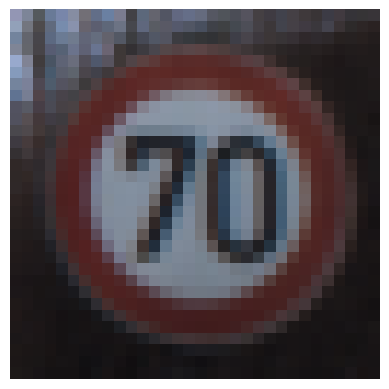

In [31]:
import cv2

# display a random image from train samples
index = random.randint(0, X_train.shape[0])
plt.imshow(X_train[index])
plt.axis('off')
print(X_train.shape)
print(Y_train[index])

In [32]:
# define a function to return the gray-scaled of an image
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

(32, 32)
4


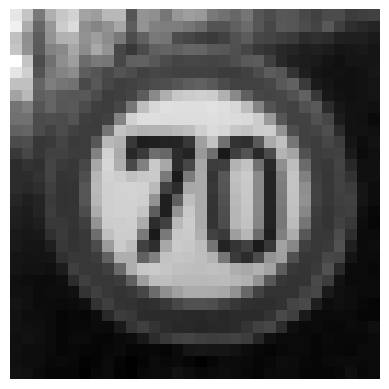

In [33]:
# display the random sample in gray-scale, that is a pre-processing method to decrese the depth of dataset
grayscale_image = grayscale(X_train[index])
plt.imshow(grayscale_image, cmap=plt.get_cmap('gray'))
plt.axis('off')
print(grayscale_image.shape)
print(Y_train[index])

In [34]:
# define a function to return the gray-scaled of an image
def equalize(img):
    return cv2.equalizeHist(img)

(32, 32)
4


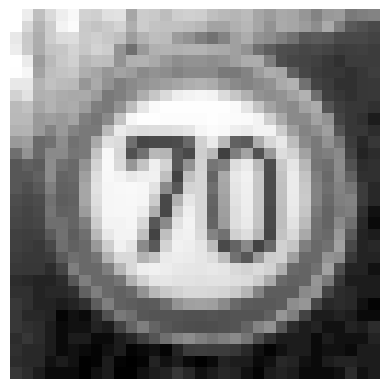

In [35]:
# display the equalized histogram of gray-scaled image, that is a pre-processing method to balance the contrast of an image
equalized_image = equalize(grayscale_image)
plt.imshow(equalized_image, cmap=plt.get_cmap('gray'))
plt.axis('off')
print(equalized_image.shape)
print(Y_train[index])

In [36]:
# define a function to pre-process an image
def preprocess(img):
    # convert the image into gray-scale
    img = grayscale(img)
    # equalize the image
    img = equalize(img)
    # normalize the image
    img = img / 255
    # return the pre-processed image
    return img

In [37]:
# pre-process the samples
X_train = np.array(list(map(preprocess, X_train)))
X_valid = np.array(list(map(preprocess, X_valid)))
X_test = np.array(list(map(preprocess, X_test)))

(34799, 32, 32)


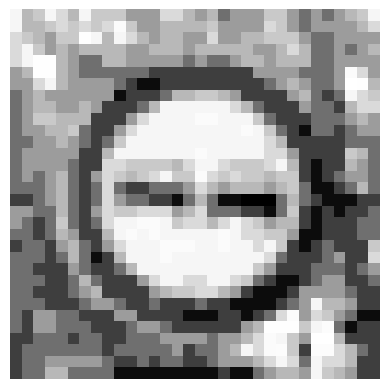

In [38]:
# display a random train sample to check the pre-preocessing
plt.imshow(X_train[random.randint(0, X_train.shape[0])], cmap=plt.get_cmap('gray'))
plt.axis('off')
print(X_train.shape)

In [39]:
# reshape the samples for using in the CNN
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_valid = X_valid.reshape(X_valid.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)
datagen.fit(X_train)

In [41]:
# one hot encode the labels
Y_train = to_categorical(Y_train, 43)
Y_valid = to_categorical(Y_valid, 43)
Y_test = to_categorical(Y_test, 43)

In [42]:
# define the model function
def modified_model():
    # choose the model
    model = Sequential()
    # add the first conv layer
    # 30 filters(features), filter size 5x5, input shape is the shape of samples, activation function relu
    # strides is the pixels that we take as a step, padding is used for keeping the size of the images, but we don't use it here as images are centeralized and borderd aren't much important
    model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
    # add another conv layer to improve the accuracy
    model.add(Conv2D(60, (5, 5), activation='relu'))
    # add the first pooling layer with pool size 2x2
    model.add(MaxPool2D(pool_size=(2, 2)))
    # add the second conv layer with fewer features to compromise computational power
    model.add(Conv2D(30, (3, 3), activation='relu'))
    # add another conv layer to improve the accuracy
    model.add(Conv2D(30, (3, 3), activation='relu'))
    # add the second pooling layer
    model.add(MaxPool2D(pool_size=(2, 2)))
    # flatten the data we achieved in the process of conv and pooling in order to use in fully connected layer
    model.add(Flatten())
    # add the first fully connected layer with 500 neurons and activation function relu
    model.add(Dense(500, activation='relu'))
    # add the dropout layer to generalize and improve the accuracy with rate 0.5, which is the recommended rate
    model.add(Dropout(0.5))
    # add the output layer which is another fully connected layer with neurons as many as the classes and activation function softmax
    model.add(Dense(num_classes, activation='softmax'))
    # compile the model using Adam algorithm with learning rate 0.001, error function categorical cross entropy and keeping the process of accuracy
    model.compile(Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    # return the LeNet model
    return model

In [43]:
# declare the model
model = modified_model()
# output a summary of the model
print(model.summary())

c:\Users\OstadeKachal\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 30)       │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │       240,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        21,543 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,023 (1.44 MB)

 Trainable params: 378,023 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# fit the model to the samples and labels, choose valid samples for validation test, 10 epochs, batch size 400, show progress bar, shuffle true and store the process in h
h = model.fit(datagen.flow(X_train, Y_train, batch_size=50),
              steps_per_epoch=X_train.shape[0]//50,
              epochs=25,
              validation_data=(X_valid, Y_valid), shuffle = 1)

Text(0.5, 0, 'epoch')

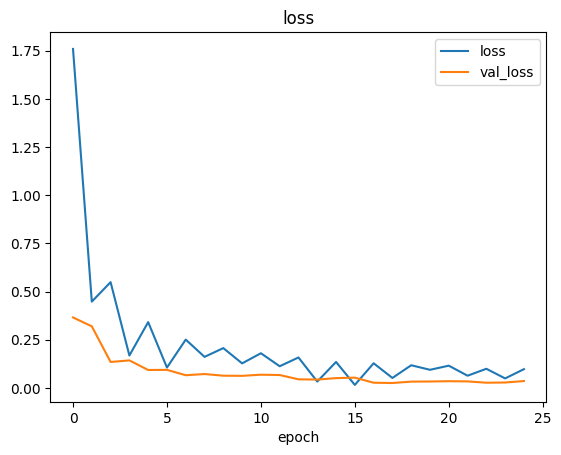

In [45]:
# plot the process of loss of train test and validation test
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

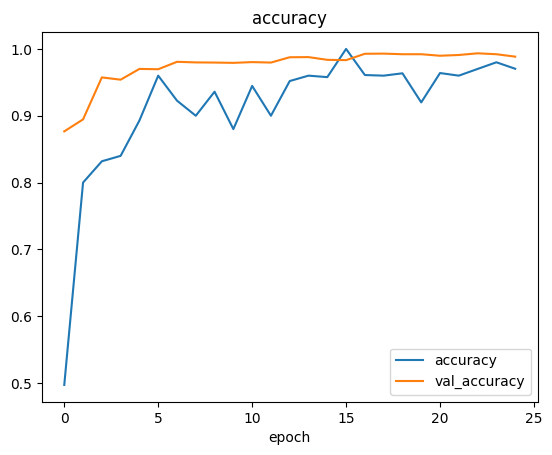

In [46]:
# plot the process of accuaracy of train test and validation test
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('accuracy')
plt.xlabel('epoch')

In [47]:
# evaluate the model on the test samples, don't show the progress bar
score = model.evaluate(X_test, Y_test, verbose=0)
# output the loss(score) and accuracy of the trained model
print(f'Test score: {score[0]}')
print(f'Test accuracy: {score[1]}')

Test score: 0.1411629617214203
Test accuracy: 0.9690419435501099


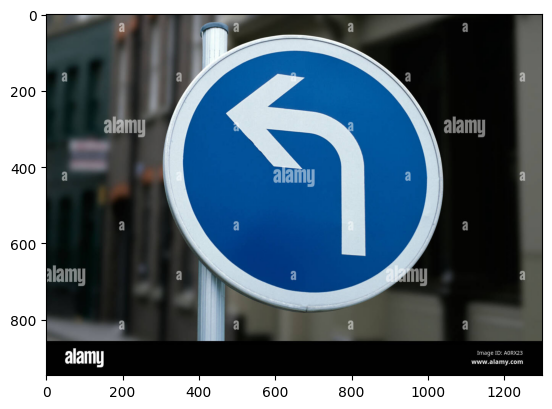

In [48]:
#predict internet number
import requests
from PIL import Image

# declare the url of the test image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
# get the image from the url and store it
response = requests.get(url, stream=True)
img = Image.open(response.raw)
# show the image in gray-scale
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


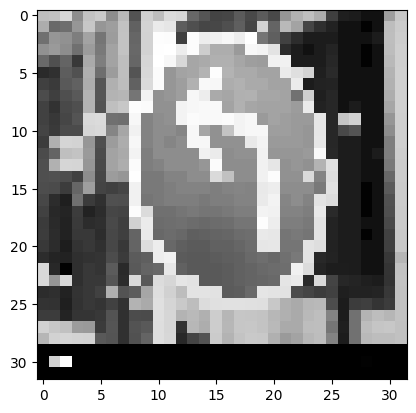

In [49]:
# convert the image into numpy array
img = np.asarray(img)
# resize the image into the desired size
img = cv2.resize(img, (32, 32))
# preprocess the test image
img = preprocess(img)
# display the preprocessed image
plt.imshow(img, cmap = plt.get_cmap('gray'))
# print the shape of the image
print(img.shape)
# reshape the image into the desired shape
img = img.reshape(1, 32, 32, 1)

In [50]:
# print the predict of the model
print("predicted sign: "+ str(np.argmax(model.predict(img), axis=1)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
predicted sign: [34]
